# Calculation of Master Bias

## Author : Sylvie Dagoret-Campagne
## Affiliation : LAL,IN2P3,CNRS
## Creation : Monday 30th 2016

CCD reduction for Monocam data (LSST)

The calculation is done by **ccdproc** python package.

http://ccdproc.readthedocs.io/en/latest/index.html


In [1]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
#config InlineBackend.rc = {}
#config Backend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")  # default config obtained from astropy examples
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from astropy.io import fits
from astropy import units as u
import ccdproc

In [3]:
import os

In [4]:
def BuildFilelist(path,name,ext='.fits',start=1,stop=99):
    '''
    Make the list of filenames required by ccdproc
    
    input:
       path : path of files
       name : common root of bias filenames
       ext  : extension of filenames
       start,stop : indexes of files
    output:
       full filename list
    '''
    filelist = []
    for num in range(start,stop+1,1):
        strnum=biasnumberstr= '{0:02d}'.format(num)  # python >= 2.6
        filename=name+strnum+ext
        fullfilename=os.path.join(path,filename)
        filelist.append(fullfilename)
    return filelist

## 1) Definition of configuration variables

In [27]:
root_filename='bias_'
ext_filename='.fits'
channel=1
startnum=1
stopnum=50
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
nb_of_channels=16  # number of CCD amplifier channels corresponding to an image inside the fits file

## 2) Build the file list for bias

In [6]:
biaslist=BuildFilelist(path,root_filename,start=startnum,stop=stopnum)

## 3) Build the list of CCDData for each of the CCS amplifiers channels

In [16]:
# all CCDPROC data collector : each channel as a list of biases data
allccd = []

In [17]:
for chan in range(1,nb_of_channels+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in biaslist ]
    allccd.append(ccd_chan)

## 4) Combine the biases for each channel

In [28]:
allccdcombinedbias = []
for ccd_chan_data in allccd:
    comb=ccdproc.Combiner(ccd_chan_data)
    mb = comb.median_combine()  # bias calculated with median
    allccdcombinedbias.append(mb)

## 5) associate each individual bias with the masterbias

For each amplifier channel
- collection of bias
- the corresponding masterbias

In [53]:
bias_and_masterbias=zip(allccd, allccdcombinedbias)

## 6) substract masterbias

In [41]:
list_subbias= []
for allb,mb in bias_and_masterbias:
    list_b=[]
    for b in allb:
        nw=ccdproc.subtract_bias(b,mb)
        list_b.append(nw)
    list_subbias.append(list_b)        

## 5) Analysis of the result

In [102]:
def ShowHistoSet(allbiases):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''  
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)
    index=-1
    # loop on indexes
    for bias in allbiases:    
        index=index+1  
        
        ix=index%4
        iy=index/4
        # loop on corrected bias file
        
        image_data=np.array([0])
        for b in bias:        
            im_data = b.data  # extract np.array from CCDproc            
            dat=im_data.flatten()
            image_data=np.append(image_data,dat)
            
        axarr[iy,ix].hist(image_data,bins=500,facecolor='blue', alpha=0.75,log=True)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].set_xlim(-50.,50.)
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_yscale('log')
        
    plt.yscale('log')
    title='Master Bias Distributions '
    plt.suptitle(title,size=16)

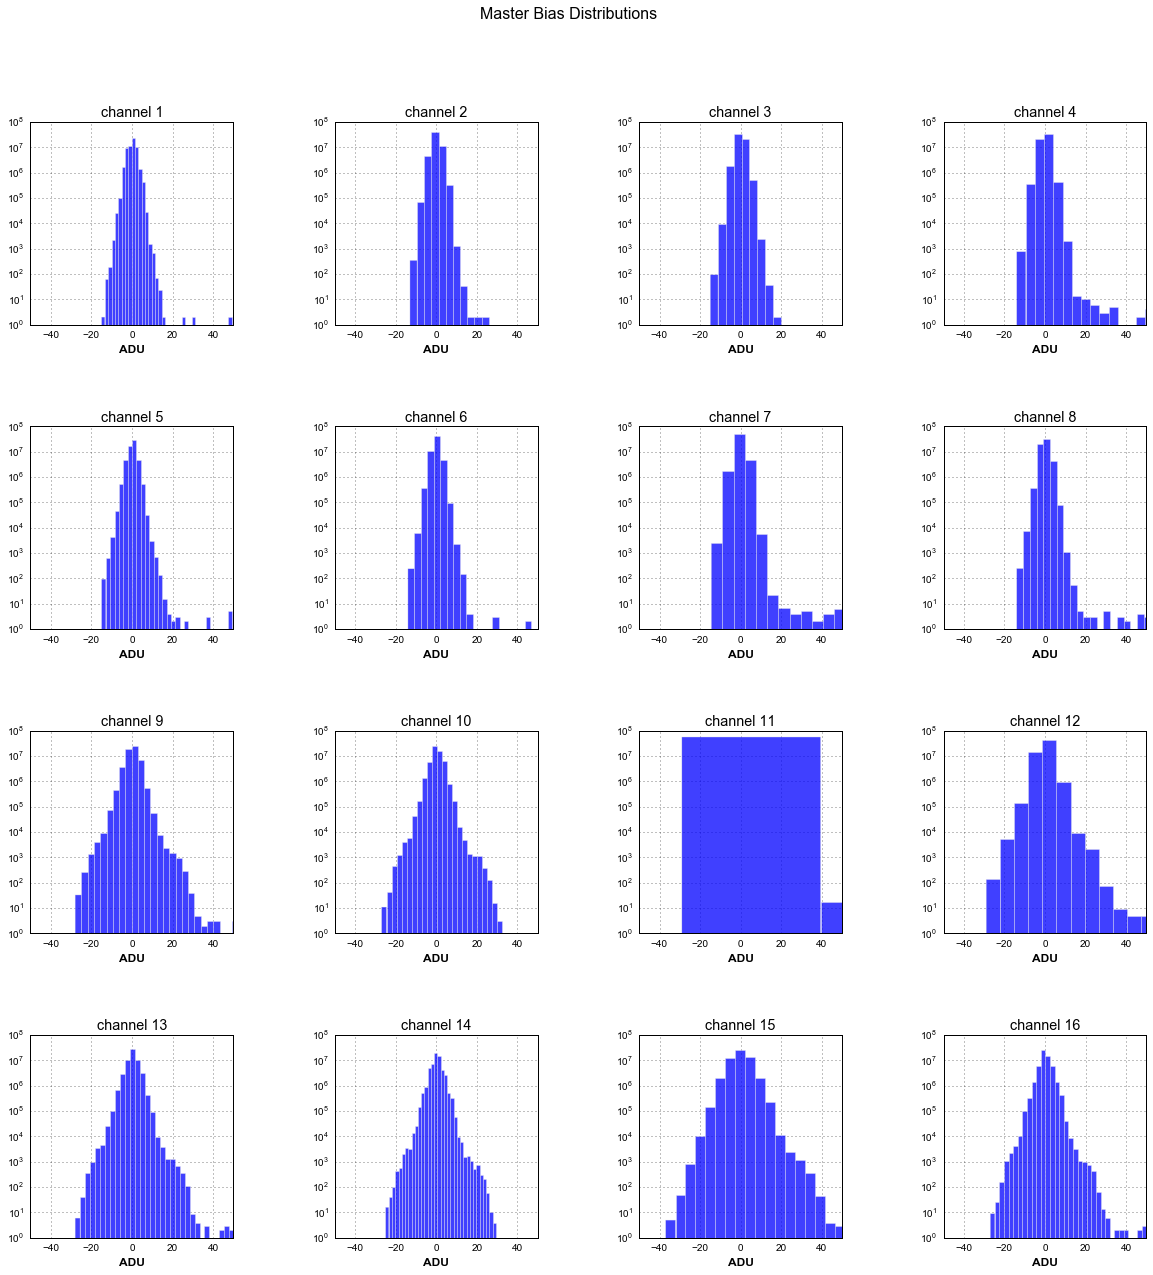

In [103]:
ShowHistoSet(list_subbias)